In [21]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from tqdm import tqdm

from modules import *
from networks import *
from training import *

COORDS = 'polar'  # cartesian, polar
ARCH = 'dual'  # dual, cascade
MODEL = 'ref'  # rau, ref, swin

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SIZE = 256 if MODEL != 'swin' else 224
transform = A.Compose([
    A.Resize(height=SIZE, width=SIZE, interpolation=cv.INTER_AREA),
    A.Lambda(image=sharpen, p=1.0),
    A.Lambda(image=polar_transform, mask=polar_transform),
    A.Normalize(),
    ToTensorV2(),
])

# Load dataset
all_images = load_files_from_dir(['../data/DRISHTI/ROI/TestImages'])
all_masks = load_files_from_dir(['../data/DRISHTI/ROI/TestMasks'])

# Shuffle
indices = np.random.permutation(len(all_images))
all_images = [all_images[i] for i in indices]
all_masks = [all_masks[i] for i in indices]

loader = load_dataset(
    all_images,
    all_masks,
    transform,
    batch_size=1,
    shuffle=False,
)

# Sample data
images, masks = next(iter(loader))
images = images.float().to(device)
masks = masks.long().to(device)

# Load models
path = rf"..\models\{COORDS}\{MODEL}\binary.pth"
checkpoint = load_checkpoint(path, map_location=device)
base_model = checkpoint['model']
base_model = base_model.eval()

path = rf"..\models\{COORDS}\{MODEL}\{ARCH}.pth"
checkpoint = load_checkpoint(path, map_location=device)
model = checkpoint['model']
model = model.eval()

Loaded dataset with 51 samples in 51 batches.
=> Loading checkpoint: ..\models\polar\ref\binary.pth
=> Loading checkpoint: ..\models\polar\ref\dual.pth


In [22]:
df = get_threshold_stats(ARCH, model, loader, base_model=base_model if ARCH == 'cascade' else None)
df

,threshold,accuracy_OD,precision_OD,npv_OD,sensitivity_OD,specificity_OD,fpr_OD,fnr_OD,dice_OD,iou_OD,...,fnr_OC,dice_OC,iou_OC,balanced_accuracy_OC,tp_OC,tn_OC,fp_OC,fn_OC,gmean_OD,gmean_OC
0,0.00,0.401042,0.401042,0.000000,1.000000,0.000000,1.000000e+00,0.000000,0.572491,0.401042,...,0.000000,0.450985,0.291143,0.500000,973097.0,0.0,2369239.0,0.0,0.000000,0.000000
1,0.01,0.974156,0.941368,0.998395,0.997699,0.958393,4.160708e-02,0.002301,0.968715,0.939329,...,0.007505,0.898484,0.815679,0.951731,965794.0,2158299.0,210940.0,7303.0,0.977849,0.950858
2,0.02,0.977595,0.950122,0.997538,0.996444,0.964975,3.502489e-02,0.003556,0.972732,0.946911,...,0.009955,0.912051,0.838322,0.957856,963410.0,2193124.0,176115.0,9687.0,0.980583,0.957315
3,0.03,0.979601,0.955648,0.996783,0.995329,0.969071,3.092932e-02,0.004671,0.975085,0.951382,...,0.012110,0.919905,0.851689,0.961104,961313.0,2213623.0,155616.0,11784.0,0.982112,0.960731
4,0.04,0.981236,0.960391,0.996034,0.994217,0.972545,2.745466e-02,0.005783,0.977011,0.955056,...,0.014066,0.925492,0.861316,0.963255,959409.0,2228449.0,140790.0,13688.0,0.983321,0.962988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.964697,0.999881,0.944401,0.912081,0.999928,7.243050e-05,0.087919,0.953965,0.911982,...,0.183734,0.894612,0.809319,0.906370,794306.0,2360886.0,8353.0,178791.0,0.954995,0.901880
97,0.97,0.962129,0.999946,0.940559,0.905617,0.999968,3.246885e-05,0.094383,0.950447,0.905573,...,0.198611,0.886098,0.795491,0.899172,779829.0,2362024.0,7215.0,193268.0,0.951623,0.893839
98,0.98,0.958445,0.999983,0.935131,0.896398,0.999990,1.048993e-05,0.103602,0.945361,0.896384,...,0.219865,0.873474,0.775370,0.888805,759147.0,2363259.0,5980.0,213950.0,0.946778,0.882137
99,0.99,0.951875,0.999999,0.925629,0.880002,1.000000,4.995207e-07,0.119998,0.936171,0.880001,...,0.257731,0.849842,0.738892,0.870196,722300.0,2364791.0,4448.0,250797.0,0.938084,0.860741


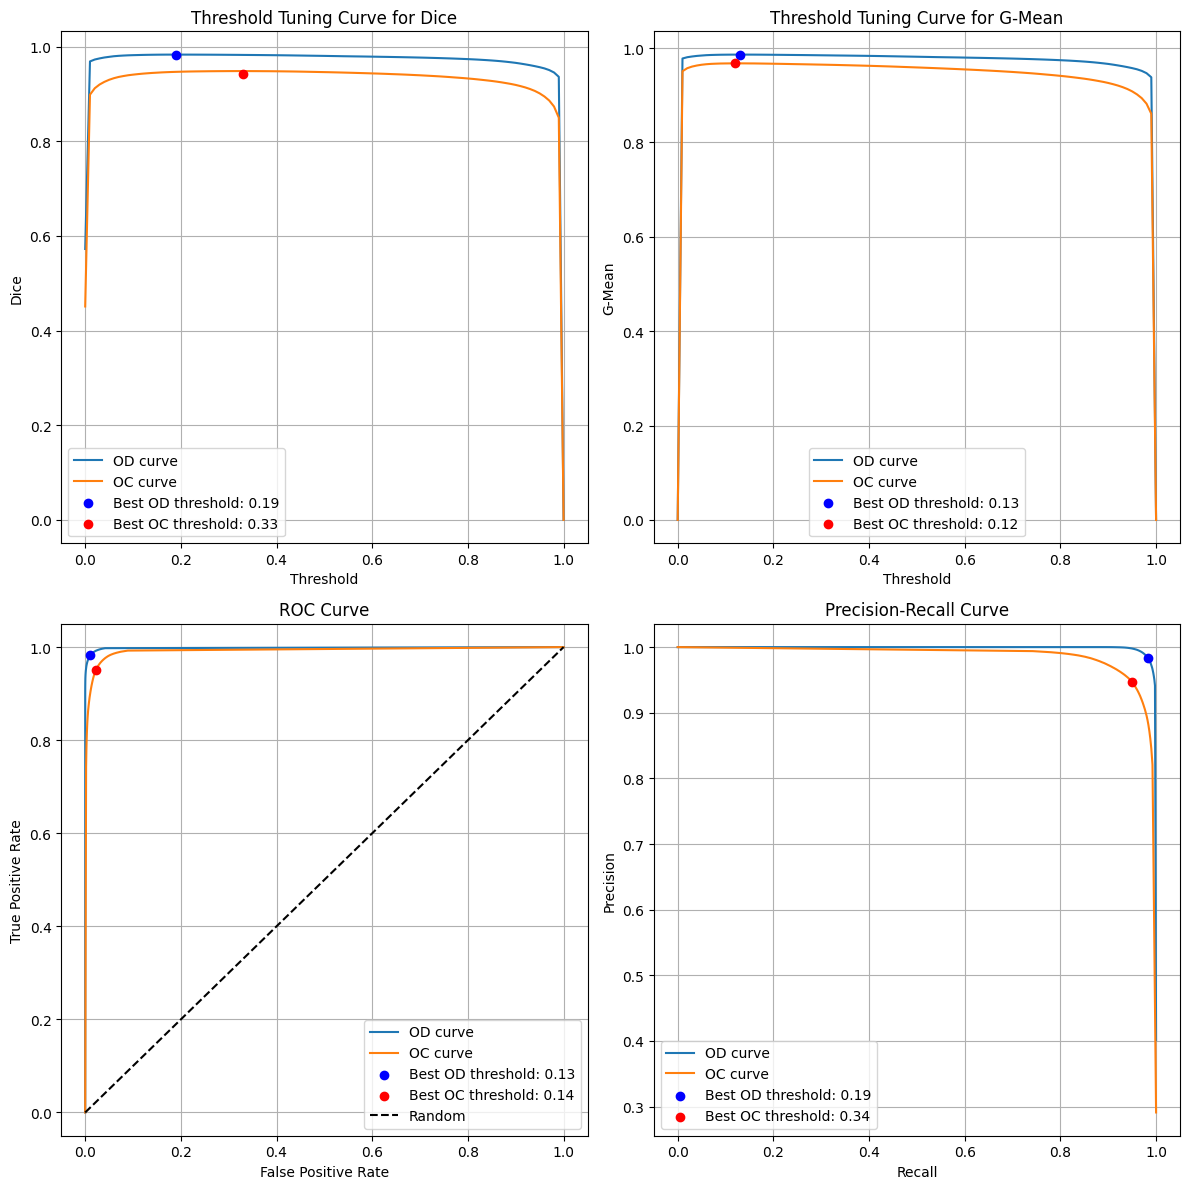

In [23]:
optimal_values = plot_curves(df, tuning_metric='dice')

od_thresh = optimal_values['pr']['OD']
oc_thresh = optimal_values['pr']['OC']

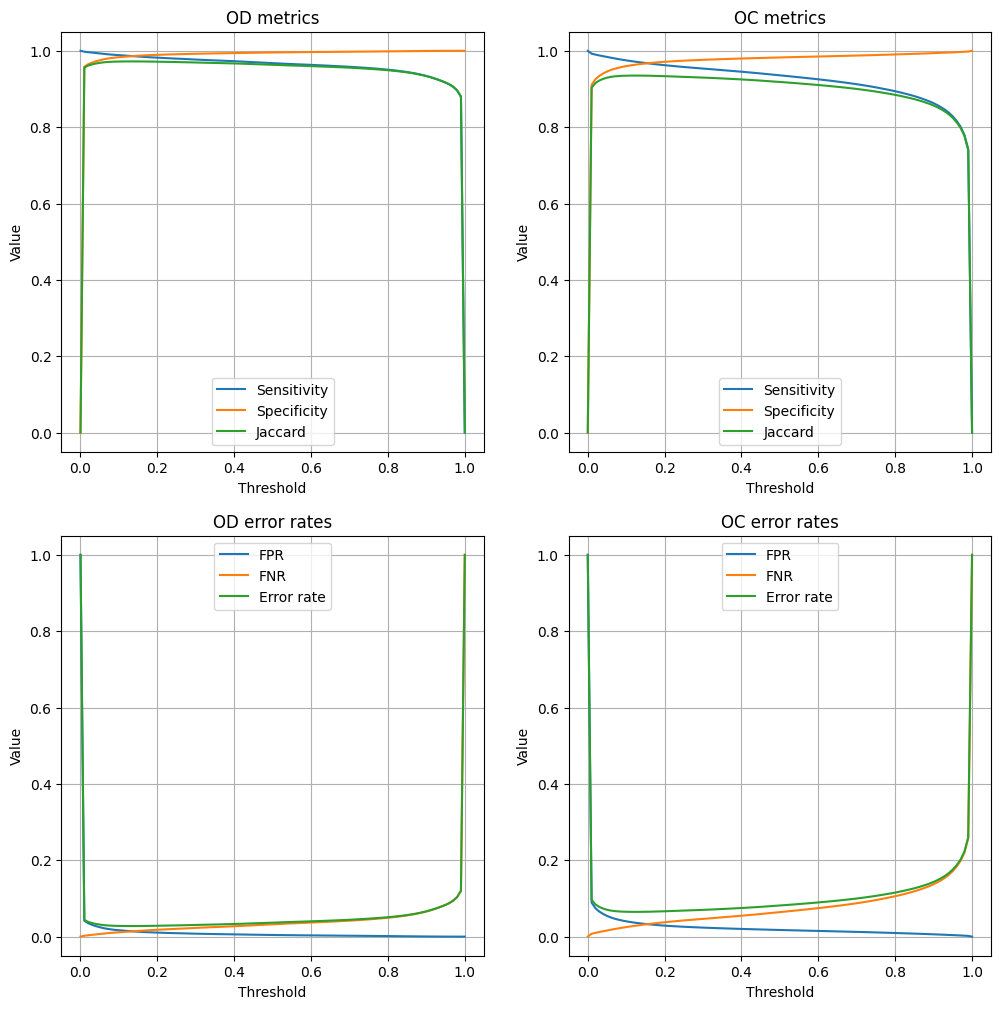

In [24]:
# Plot metrics
_, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(df['threshold'], df['sensitivity_OD'], label='Sensitivity')
ax[0, 0].plot(df['threshold'], df['specificity_OD'], label='Specificity')
ax[0, 0].plot(df['threshold'], df['specificity_OD'] + df['sensitivity_OD'] - 1, label='Jaccard')
ax[0, 0].set_xlabel('Threshold')
ax[0, 0].set_ylabel('Value')
ax[0, 0].set_title('OD metrics')
ax[0, 0].legend()
ax[0, 0].grid(True)

ax[0, 1].plot(df['threshold'], df['sensitivity_OC'], label='Sensitivity')
ax[0, 1].plot(df['threshold'], df['specificity_OC'], label='Specificity')
ax[0, 1].plot(df['threshold'], df['specificity_OC'] + df['sensitivity_OC'] - 1, label='Jaccard')
ax[0, 1].set_xlabel('Threshold')
ax[0, 1].set_ylabel('Value')
ax[0, 1].set_title('OC metrics')
ax[0, 1].legend()
ax[0, 1].grid(True)

ax[1, 0].plot(df['threshold'], df['fpr_OD'], label='FPR')
ax[1, 0].plot(df['threshold'], df['fnr_OD'], label='FNR')
ax[1, 0].plot(df['threshold'], df['fpr_OD'] + df['fnr_OD'], label='Error rate')
ax[1, 0].set_xlabel('Threshold')
ax[1, 0].set_ylabel('Value')
ax[1, 0].set_title('OD error rates')
ax[1, 0].legend()
ax[1, 0].grid(True)

ax[1, 1].plot(df['threshold'], df['fpr_OC'], label='FPR')
ax[1, 1].plot(df['threshold'], df['fnr_OC'], label='FNR')
ax[1, 1].plot(df['threshold'], df['fpr_OC'] + df['fnr_OC'], label='Error rate')
ax[1, 1].set_xlabel('Threshold')
ax[1, 1].set_ylabel('Value')
ax[1, 1].set_title('OC error rates')
ax[1, 1].legend()
ax[1, 1].grid(True)

plt.show()

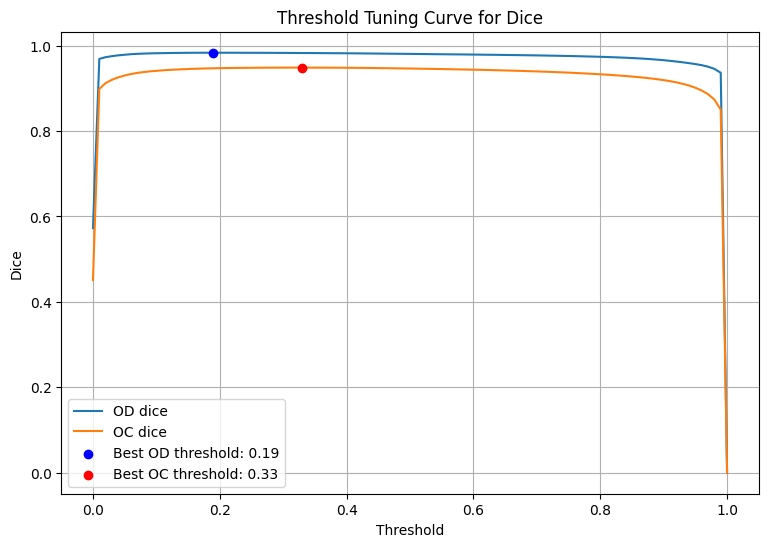

(0.19, 0.33)

In [25]:
threshold_tuning_curve(df, tuning_metric='dice')

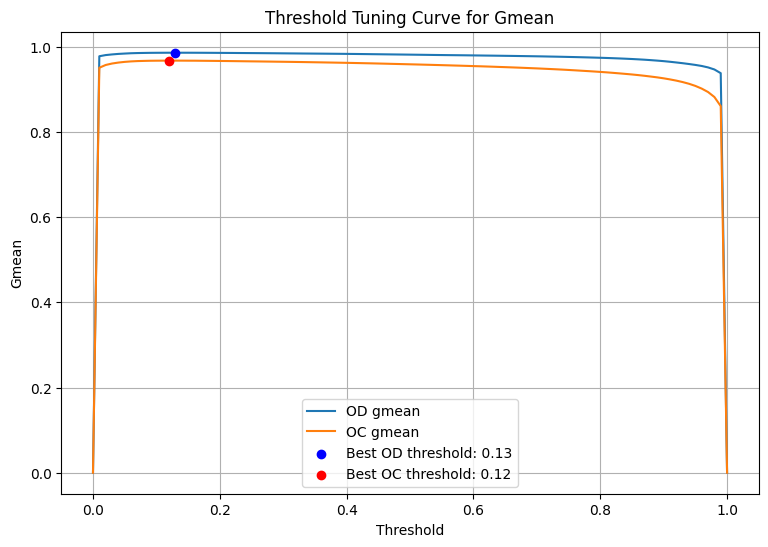

(0.13, 0.12)

In [26]:
threshold_tuning_curve(df, tuning_metric='gmean')

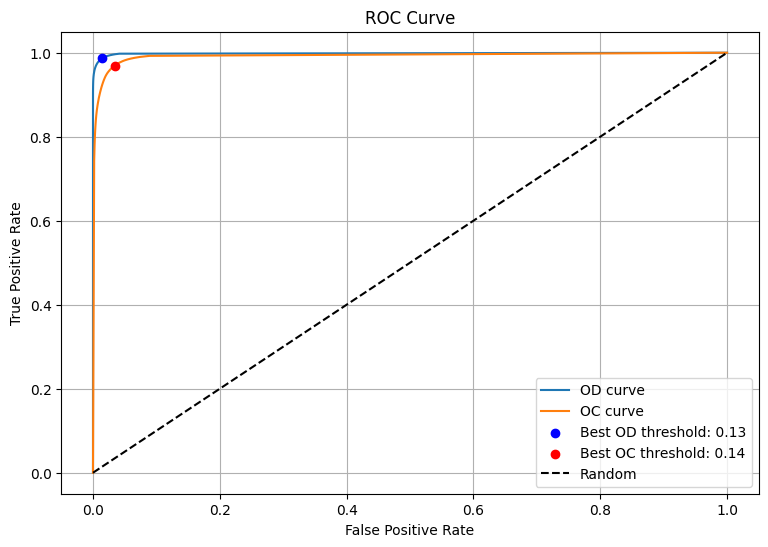

(0.13, 0.14)

In [27]:
roc_curve(df)

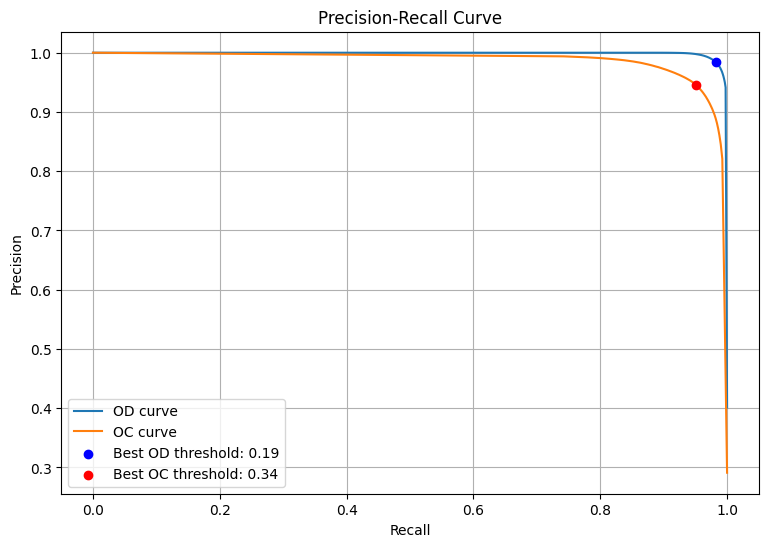

(0.19, 0.34)

In [28]:
precision_recall_curve(df)

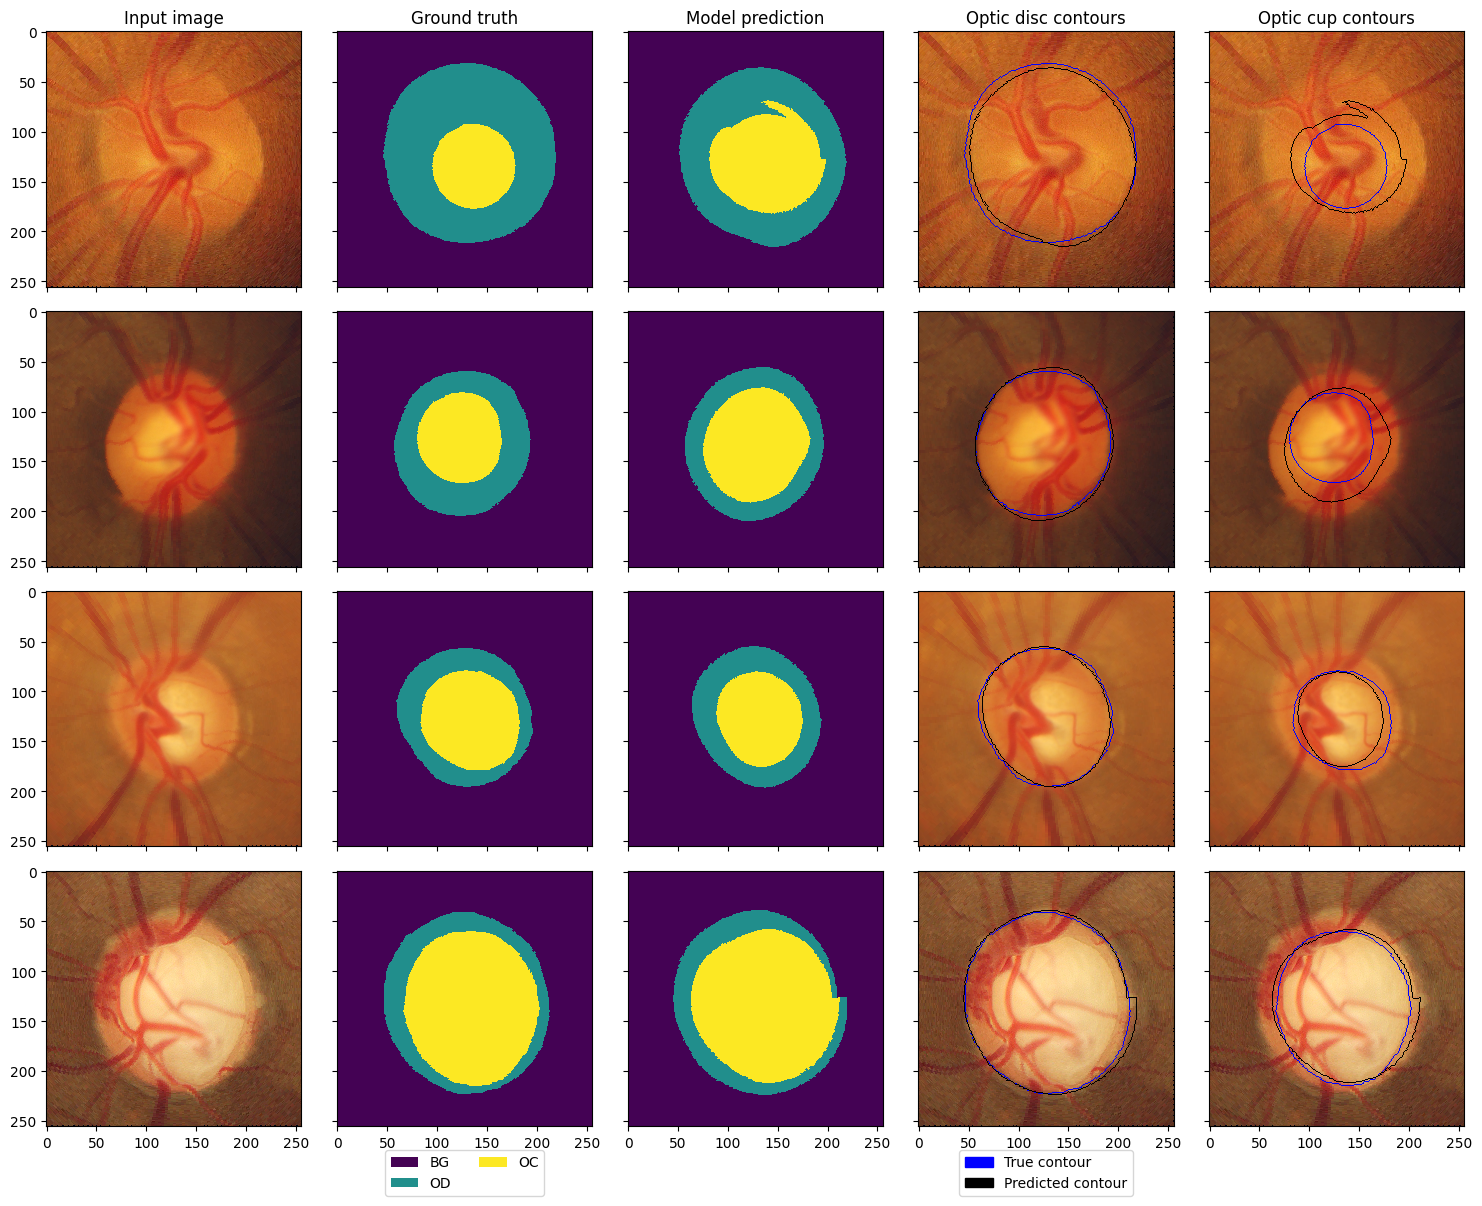

In [141]:
plot_results_from_loader(
    ARCH, loader, model, device, base_model=base_model,
    n_samples=4, od_thresh=od_thresh, oc_thresh=oc_thresh,
    post_process_fn=postprocess,
    inter_process_fn=interprocess if ARCH == 'cascade' else None,
    inverse_transform=undo_polar_transform,
    types=['image', 'mask', 'prediction', 'OD contour', 'OC contour'],
)

torch.Size([1, 3, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 256, 256]) torch.Size([1, 2, 256, 256]) tensor(0.0962, device='cuda:0')


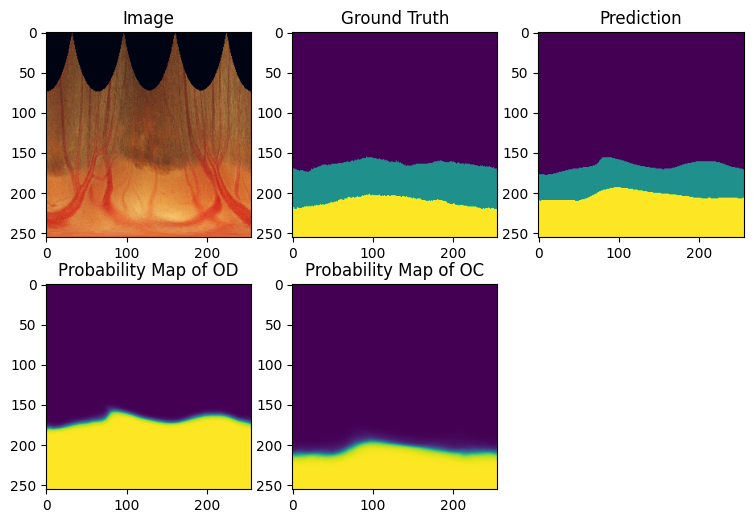

In [192]:
criterion = ComboLoss(1)

for images, masks in loader:
    images, masks = images.float(), masks.long()
    print(images.shape, masks.shape)
    preds, probs, loss = predict_dual(model, images, masks, device, criterion, od_threshold=0.2, oc_threshold=0.25)
    print(preds.shape, probs.shape, loss)

    for i in range(images.shape[0]):
        img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
        img -= img.min()
        img /= img.max()
        mask = masks[i].detach().cpu().numpy()
        pred = preds[i].detach().cpu().numpy()
        prob = probs[i].detach().cpu().numpy()

        plt.figure(figsize=(9, 6))
        plt.subplot(2, 3, 1)
        plt.imshow(img)
        plt.title('Image')

        plt.subplot(2, 3, 2)
        plt.imshow(mask)
        plt.title('Ground Truth')

        plt.subplot(2, 3, 3)
        plt.imshow(pred)
        plt.title('Prediction')

        prob_od = inverse_polar_transform(prob[0])
        prob_oc = inverse_polar_transform(prob[1])

        plt.subplot(2, 3, 4)
        plt.imshow(prob[0])
        plt.title('Probability Map of OD')

        plt.subplot(2, 3, 5)
        plt.imshow(prob[1])
        plt.title('Probability Map of OC')

        plt.subplot(2, 3, 6)
        plt.axis('off')
        plt.show()
    break